In [1]:
# Colab cell
try:
    import google.colab
    IN_COLAB = True
    !wget -q https://raw.githubusercontent.com/Competencia-de-Climate-Change/WeatherBench/master/src/ml_training.py
    !pip install -q -U zarr
    !pip install -q -U fsspec
    !pip install -q -U gcsfs
    !pip install -q -U xarray
except:
    IN_COLAB = False

In [2]:
import xarray as xr
import fsspec

%load_ext autoreload
%autoreload 2

ds = xr.open_zarr(fsspec.get_mapper('gcs://weather-bench/region_zarr/'), consolidated=True)

print("Tamaño en GB:", ds.nbytes / 1e9)

Tamaño en GB: 19.324476644


# Linear Regression for $Z500$, $T850$ and $T2M$

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import pickle

from src.ml_training import *

# from dask_ml.wrappers import ParallelPostFit

def to_pickle(obj, fn):
    with open(fn, 'wb') as f:
        pickle.dump(obj, f)
def read_pickle(fn):
    with open(fn, 'rb') as f:
        return pickle.load(f)
    
results = 'results'
verbose = False

import os
if not os.path.exists(results):
    os.makedirs(results)

## Data Loading

In [5]:
z_500 = ds.z.sel(level=500).drop('level')
t_850 = ds.t.sel(level=500).drop('level')

t2m   = ds.t2m

data = xr.merge([z_500, t_850, t2m])

data_train = data.sel(time=slice('1979', '2016'))
data_test  = data.sel(time=slice('2017', '2018'))

z_test   = load_test_data('z', ds=ds)
t_test   = load_test_data('t', ds=ds)
t2m_test = load_test_data('t2m', ds=ds)

test_data = xr.merge([z_test, t_test, t2m_test])

_, nlat, nlon = data_train.z.shape

nlat, nlon

Selecting from ds...
Selecting from ds...


(12, 14)

In [6]:
# Compute normalization statistics
# Let's only take a sample of the time to speed this up.
data_mean = data_train.isel(time=slice(0, None, 10000)).mean().load()
data_std  = data_train.isel(time=slice(0, None, 10000)).std().load()


# Normalize datasets
data_train = (data_train - data_mean) / data_std
data_test  = (data_test - data_mean)  / data_std

### Define combinations of training data

In [7]:
# Inputs and Outputs
experiments = [
    [['t'],             ['t']],
    [['z', 't'],        ['t']],
    [['z', 't', 't2m'], ['t']],
    [['t2m'],           ['t2m']],
    [['z', 't'],        ['t2m']],
    [['z', 't', 't2m'], ['t2m']],
]

lead_time = 3*24 # Predict 3 days from current time
lead_time_str = '3d'

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import MultiTaskLasso, MultiTaskLassoCV
from sklearn.linear_model import MultiTaskElasticNet, MultiTaskElasticNetCV

## Run Experiments

In [9]:
preds  = {
    'lr'        : [],
    'ridge'     : [],
    'ridge_cv'  : [],
    'lasso'     : [],
    'elasticnet': []
}

models = {
    'lr'        : [],
    'ridge'     : [],
    'ridge_cv'  : [],
    'lasso'     : [],
    'elasticnet': []
}

train_mse = {
    'lr'        : [],
    'ridge'     : [],
    'ridge_cv'  : [],
    'lasso'     : [],
    'elasticnet': []
}

test_mse = {
    'lr'        : [],
    'ridge'     : [],
    'ridge_cv'  : [],
    'lasso'     : [],
    'elasticnet': []
}

weighted_mse = {
    'lr'        : [],
    'ridge'     : [],
    'ridge_cv'  : [],
    'lasso'     : [],
    'elasticnet': []
}

model_args = [
    [LinearRegression,    'lr', {}], 
    [Ridge,               'ridge', {}], 
    [RidgeCV,             'ridge_cv', {'alphas': [0.001, 0.01, 1., 10., 50.]}],
    [MultiTaskLasso,      'lasso', {'tol' : 0.001, 'selection' : 'random'}],
    [MultiTaskElasticNet, 'elasticnet', {'tol' : 0.001, 'selection' : 'random'}]
]

In [14]:
for model in model_args:
    model_fun, model_str, extra_args = model
    
    print('Running:', model_str)
    for idx, (i, o) in enumerate(experiments):
        print(f'{idx}: Input variables = {i}; output variables = {o}')
        
        X_train, y_train, X_test, y_test, time = create_X_y_time(input_vars=i, 
                                                                 output_vars=o, 
                                                                 data=[data_train, data_test], 
                                                                 lead_time=lead_time, 
                                                                 data_subsample=5)
        
        data_needed_train = [X_train, y_train, X_test, y_test, nlat, nlon]
        
        predictions, model_res, mse_train, mse_test = train_regression(model=model_fun,
                                                                       data=data_needed_train,
                                                                       num_outputs=len(o),
                                                                       extra_args=extra_args,
                                                                       verbose=False)
        
        predictions = unnormalize_preds(preds=predictions, 
                                        output_vars=o, 
                                        valid_time=time, 
                                        lat_lon=[data_train.lat, data_train.lon],
                                        data_std=data_std, 
                                        data_mean=data_mean)

        preds[model_str].append(predictions)
        models[model_str].append(model_res)

        # Compute Weighted RMSE: RMSE with a weight that takes into account grid location
        r = compute_weighted_rmse(predictions, test_data).compute()
        if verbose:
            print('; '.join([f'{v} = {r[v].values}' for v in r]) + '\n')
        
        train_mse[model_str].append(mse_train)
        test_mse[model_str].append(mse_test)
        weighted_mse[model_str].append(r)

        # Save models
        preds_nc_str  = f'{results}/{model_str}_{lead_time_str}_{"_".join(i)}_{"_".join(o)}.nc'
        model_res_str = f'{results}/{model_str}_{lead_time_str}_{"_".join(i)}_{"_".join(o)}.pkl'
        
        predictions.to_netcdf(preds_nc_str)
        to_pickle(model_res, model_res_str)
    print('----------------------------------------------------------------------------')

Running: lr
0: Input variables = ['t']; output variables = ['t']
1: Input variables = ['z', 't']; output variables = ['t']
2: Input variables = ['z', 't', 't2m']; output variables = ['t']
3: Input variables = ['t2m']; output variables = ['t2m']
4: Input variables = ['z', 't']; output variables = ['t2m']
5: Input variables = ['z', 't', 't2m']; output variables = ['t2m']
----------------------------------------------------------------------------
Running: ridge
0: Input variables = ['t']; output variables = ['t']
1: Input variables = ['z', 't']; output variables = ['t']
2: Input variables = ['z', 't', 't2m']; output variables = ['t']
3: Input variables = ['t2m']; output variables = ['t2m']
4: Input variables = ['z', 't']; output variables = ['t2m']
5: Input variables = ['z', 't', 't2m']; output variables = ['t2m']
----------------------------------------------------------------------------
Running: ridge_cv
0: Input variables = ['t']; output variables = ['t']
1: Input variables = ['z', '

In [28]:
import pandas as pd

results_df = pd.DataFrame(columns=['model', 'input', 'output',  'train_mse', 'test_mse', 'weighted_mse'])

block_rows = []
for key in models.keys():
    # repeat key as many time as needed to have a long df
    first_three_cols = np.hstack((np.array([key] * len(experiments)).reshape(len(experiments), 1), 
                                  np.array(experiments, dtype='object')))
    block_rows.append(first_three_cols)
    
block_rows = np.array(block_rows).reshape(len(models.keys()) * len(experiments), 3) 

results_df['model'] = block_rows[:, 0]
results_df['input'] = block_rows[:, 1]
results_df['output'] = block_rows[:, 2]


train_mse_col = []
for model, ds_list in train_mse.items():
    train_mse_col += ds_list

test_mse_col = []
for model, ds_list in test_mse.items():
    test_mse_col += ds_list
    

weighted_mse_col = []
for model, ds_list in weighted_mse.items():
    print(model)
    model_metrics = []
    for ds in ds_list:
        exp_metrics = []
        for var in list(ds.variables):
            exp_metrics.append(round(float(ds[var].values), 4))

        model_metrics.append(exp_metrics)
    weighted_mse_col += model_metrics

    
print('\nNumber of rows equals number of metrics? ', results_df.shape[0] == len(train_mse_col[1:]))

results_df['train_mse'] = train_mse_col[1:]
results_df['test_mse'] = test_mse_col[1:]

results_df['weighted_mse'] = weighted_mse_col[1:]
results_df['weighted_mse'] = results_df['weighted_mse'].apply(lambda x : x[0])

results_df['output'] = results_df['output'].apply(lambda x: x[0])

results_df.to_csv('results_linear_regression.csv')
results_df

lr
ridge
ridge_cv
lasso
elasticnet

Number of rows equals number of metrics?  True


,model,input,output,train_mse,test_mse,weighted_mse
0,lr,[t],t,0.104016,0.106154,22.8688
1,lr,"[z, t]",t,0.094493,0.099225,22.8797
2,lr,"[z, t, t2m]",t,0.091843,0.098531,22.8513
3,lr,[t2m],t2m,0.039627,0.039738,2.0013
4,lr,"[z, t]",t2m,0.056119,0.057563,2.5032
5,lr,"[z, t, t2m]",t2m,0.036070,0.037659,1.9424
6,ridge,[t],t,0.104016,0.106151,22.8688
7,ridge,"[z, t]",t,0.094501,0.099162,22.8783
8,ridge,"[z, t, t2m]",t,0.091850,0.098460,22.8506
9,ridge,[t2m],t2m,0.039627,0.039731,2.0011


In [24]:
import seaborn as sns
sns.set_style('darkgrid')

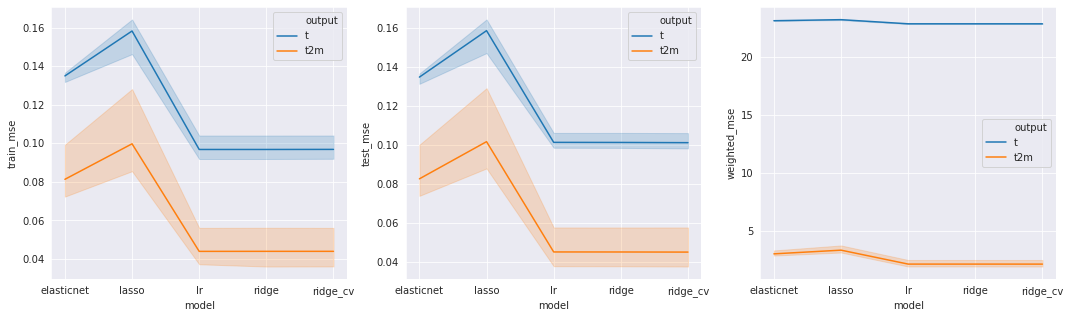

In [25]:
f, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

sns.lineplot(data=results_df, x='model', y='train_mse', hue='output', ax=axs[0])
sns.lineplot(data=results_df, x='model', y='test_mse',  hue='output',ax=axs[1])
sns.lineplot(data=results_df, x='model', y='weighted_mse', hue='output', ax=axs[2])

plt.savefig('results/linear_regresion_mse.png')
f.show()

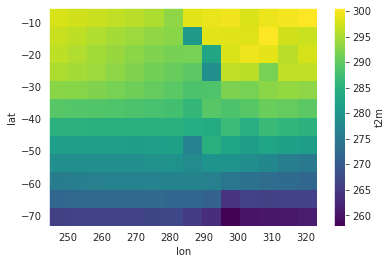

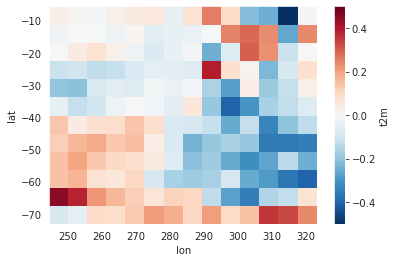

In [26]:
best_pred_t2m = xr.open_dataset('results/lr_3d_z_t_t2m_t2m.nc')
best_pred_t2m.t2m.mean('time').plot()
plt.show()

(best_pred_t2m - (data_test * data_std + data_mean)['t2m']).mean('time').t2m.plot()
f.savefig('results/lr_3d_z_t_t2m_t2m__difference.png')
plt.show()

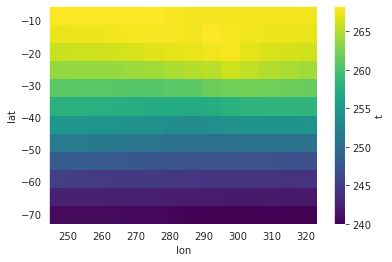

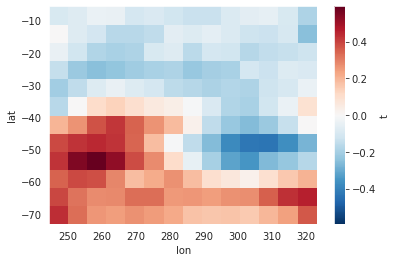

In [27]:
best_pred_t = xr.open_dataset('results/lr_3d_z_t_t2m_t.nc')
best_pred_t.t.mean('time').plot()
plt.show()

(best_pred_t - (data_test * data_std + data_mean)).mean('time')['t'].plot()
f.savefig('results/lr_3d_z_t_t2m_t__difference.png')
plt.show()